# SANet

Park and Lee propose [SANet](https://arxiv.org/abs/1812.02342v5), an image style transfer architecture which aims to improve performance compared to previous work using a novel style-attentional network and identity loss function. 

Initially, the content and style images are forwarded to two pretrained VGG-19 encoders. To combine the global and local style patterns, two style-attentional networks (SANets) learns the mapping between the content and style features. The proposed SANet is a modified version of the [self-attention mechanism](https://arxiv.org/abs/1706.03762) proposed by Vaswani et al. The self-attention mechanism captures the relative dependencies within an input image by attending to each position and calculating their weighted importance. The SANets takes the encoded VGG content and style feature maps and creates a mapping of the content and style images. The SANet layer also upsamples its intermediate style map output which improves the model's ability to learn local style patterns. Finally, a 3x3 convolution combines the feature maps. The stylised image is then synthesised by the decoder.

To maintain the structure of the content images and characteristics of the style images, Park and Lee propose an a novel identity loss function which unlike content and style losses, takes two of the same content or style images through the forward pass of the network. Thus, the identity loss evaluates how much the model deviates from the original characteristics of the content and style images.

| ![sanet_architecture.png](./images/sanet_architecture.png) | 
|:--:| 
| *SANet Architecture* |

Code sourced from https://github.com/GlebSBrykin/SANET/tree/master

# Imports

In [1]:
import torch.nn as nn
import torch

import models.SANet as SANet
import utils.data as data
from utils.eval import compute_ssim, plot_results

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset and Dataloaders

In [2]:
import torchvision.transforms as transforms

val_tf = transforms.Compose([
    transforms.Resize(size=(128, 128)),
    transforms.ToTensor(),
])

_, content_validloader, _, _, style_validloader, _ = data.get_dataloaders(bs=64, valid_tf=val_tf)


# Model Evaluation Functions

To evaluate model performance quantitatively, we compute the structural similarity (SSIM), the inference time and the content and style loss.

1. The structural similarity assesses the difference in perceptual image quality between the content and stylised images based on the degradation of structural information. The SSIM score extracts three key features: luminance, contrast, and structure.

| ![ssim.png](./images/ssim.png) | 
|:--:| 
| *The SSIM measurement system* |

The generated SSIM score is a value between -1 and +1. A value of +1 indicates that the two images are very similar while a value of -1 indicates that the images are very different. Therefore, a higher value indicates a more performant style transfer result as the stylised image has not altered the original content structural information significantly, also known as content leakage.

To generate this score, we use scikit-image's `structural_similarity` function which computes the *mean* structural similarity index between our content and stylised image in each batch of the testset. 

2. The content and style loss quantifies the difference between the predicted outputs and the ground truth values. To measure the content loss, we measure the mean squared error (MSE) between the content and generated stylised images. Likewise for style loss, we measure the MSE between the style and stylised image.

A lower value for the content/style loss is desirable since it suggests that the style transfer model is good at stylising the content and style datasets to the expected outcome (both structurally and descriptively similar). We use the MSE loss here because it penalizes errors more heavily, making it suitable for situations where outliers in the stylised image might have significant impact on style transfer performance.


In [3]:
# Code below has been adapted from https://github.com/EndyWon/MicroAST/blob/main/metrics/calc_cs_loss.py
def calc_mean_std(feat, eps=1e-5):
    # eps is a small value added to the variance to avoid divide-by-zero.
    size = feat.size()
    assert (len(size) == 4)
    N, C = size[:2]
    feat_var = feat.view(N, C, -1).var(dim=2) + eps
    feat_std = feat_var.sqrt().view(N, C, 1, 1)
    feat_mean = feat.view(N, C, -1).mean(dim=2).view(N, C, 1, 1)
    return feat_mean, feat_std

def calc_content_loss(input, target):
    assert (input.size() == target.size())
    return torch.nn.MSELoss()(input, target)

def calc_style_loss(input, target):
    input_mean, input_std = calc_mean_std(input)
    target_mean, target_std = calc_mean_std(target)
    return torch.nn.MSELoss()(input_mean, target_mean) + torch.nn.MSELoss()(input_std, target_std)

def compute_style_loss(style_images, stylised_images, net):
    """Compute the style loss between the style images and stylised images"""
    enc_1 = net[0]
    enc_2 = net[1]
    enc_3 = net[2]
    enc_4 = net[3]
    enc_5 = net[4]
    loss_s = 0.0
    output1_1 = enc_1(style_images)
    style1_1 = enc_1(stylised_images) 
    loss_s += calc_style_loss(output1_1, style1_1)
    
    output2_1 = enc_2(output1_1)
    style2_1 = enc_2(style1_1)
    loss_s += calc_style_loss(output2_1, style2_1)

    output3_1 = enc_3(output2_1)
    style3_1 = enc_3(style2_1)
    loss_s += calc_style_loss(output3_1, style3_1)

    output4_1 = enc_4(output3_1)
    style4_1 = enc_4(style3_1)
    loss_s += calc_style_loss(output4_1, style4_1)

    output5_1 = enc_5(output4_1)
    style5_1 = enc_5(style4_1)
    loss_s += calc_style_loss(output5_1, style5_1)
    
    return float(loss_s / 5)
        
def compute_content_loss(content_images, stylised_images, net):
    """Compute the content loss between the content images and stylised images"""
    enc_1 = net[0]
    enc_2 = net[1]
    enc_3 = net[2]
    enc_4 = net[3]
    enc_5 = net[4]
    
    loss_c = 0.0

    output1 = enc_4(enc_3(enc_2(enc_1(content_images))))
    content1 = enc_4(enc_3(enc_2(enc_1(stylised_images))))

    loss_c += calc_content_loss(output1, content1)
    
    output2 = enc_5(output1)
    content2 = enc_5(content1)
    
    loss_c += calc_content_loss(output2, content2)
        
    return float(loss_c / 2)

# Load pretrained model

In [4]:
decoder = SANet.decoder
vgg = SANet.vgg
transform = SANet.Transform(in_planes=512)
decoder.load_state_dict(torch.load('./models/output/SANet/decoder_iter_500000.pth'))
vgg.load_state_dict(torch.load('./models/output/SANet/vgg_normalised.pth'))
transform.load_state_dict(torch.load('./models/output/SANet/transformer_iter_500000.pth'))

<All keys matched successfully>

# Run model evaluation

In [5]:
def SANet_eval(decoder, vgg, transform, content_loader, style_loader):
    decoder.eval()
    transform.eval()
    vgg.eval()

    enc_1 = nn.Sequential(*list(vgg.children())[:4])     # input -> relu1_1
    enc_2 = nn.Sequential(*list(vgg.children())[4:11])   # relu1_1 -> relu2_1
    enc_3 = nn.Sequential(*list(vgg.children())[11:18])  # relu2_1 -> relu3_1
    enc_4 = nn.Sequential(*list(vgg.children())[18:31])  # relu3_1 -> relu4_1
    enc_5 = nn.Sequential(*list(vgg.children())[31:44])  # relu4_1 -> relu5_1

    enc_1.to(device)
    enc_2.to(device)
    enc_3.to(device)
    enc_4.to(device)
    enc_5.to(device)
    transform.to(device)
    decoder.to(device)
    
    with torch.no_grad():
        ssim_sum = 0.0
        total_samples = 0
        running_content_loss, running_style_loss = 0.0, 0.0
        for content, style in zip(content_loader, style_loader):
            # Move content and style batches to device
            content_images = content
            content_images = content_images.to(device)
            
            style_images, style_labels = style
            style_images, style_labels = style_images.to(device), style_labels.to(device)
            
            # Create stylised images
            content4_1 = enc_4(enc_3(enc_2(enc_1(content_images))))
            content5_1 = enc_5(content4_1)

            style4_1 = enc_4(enc_3(enc_2(enc_1(style_images))))
            style5_1 = enc_5(style4_1)

            stylised_images = decoder(transform(content4_1, style4_1, content5_1, style5_1))
            stylised_images.clamp(0, 255)

            # Display qualitative evaluation metrics on first batch
            if total_samples == 0:
                plot_results(content_images, style_images, style_labels, stylised_images, nrows=5, model_name="SANet")

            # Compute quantitative evaluation metrics
            ssim_sum += compute_ssim(content_images, stylised_images)
            running_content_loss += compute_content_loss(content_images, stylised_images, [enc_1, enc_2, enc_3, enc_4, enc_5])
            running_style_loss += compute_style_loss(style_images, stylised_images, [enc_1, enc_2, enc_3, enc_4, enc_5])
            
            total_samples += style_labels.size(0)
            
    avg_ssim = ssim_sum / total_samples
    avg_content_loss = running_content_loss / total_samples
    avg_style_loss = running_style_loss / total_samples

    return avg_ssim, avg_content_loss, avg_style_loss
        

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


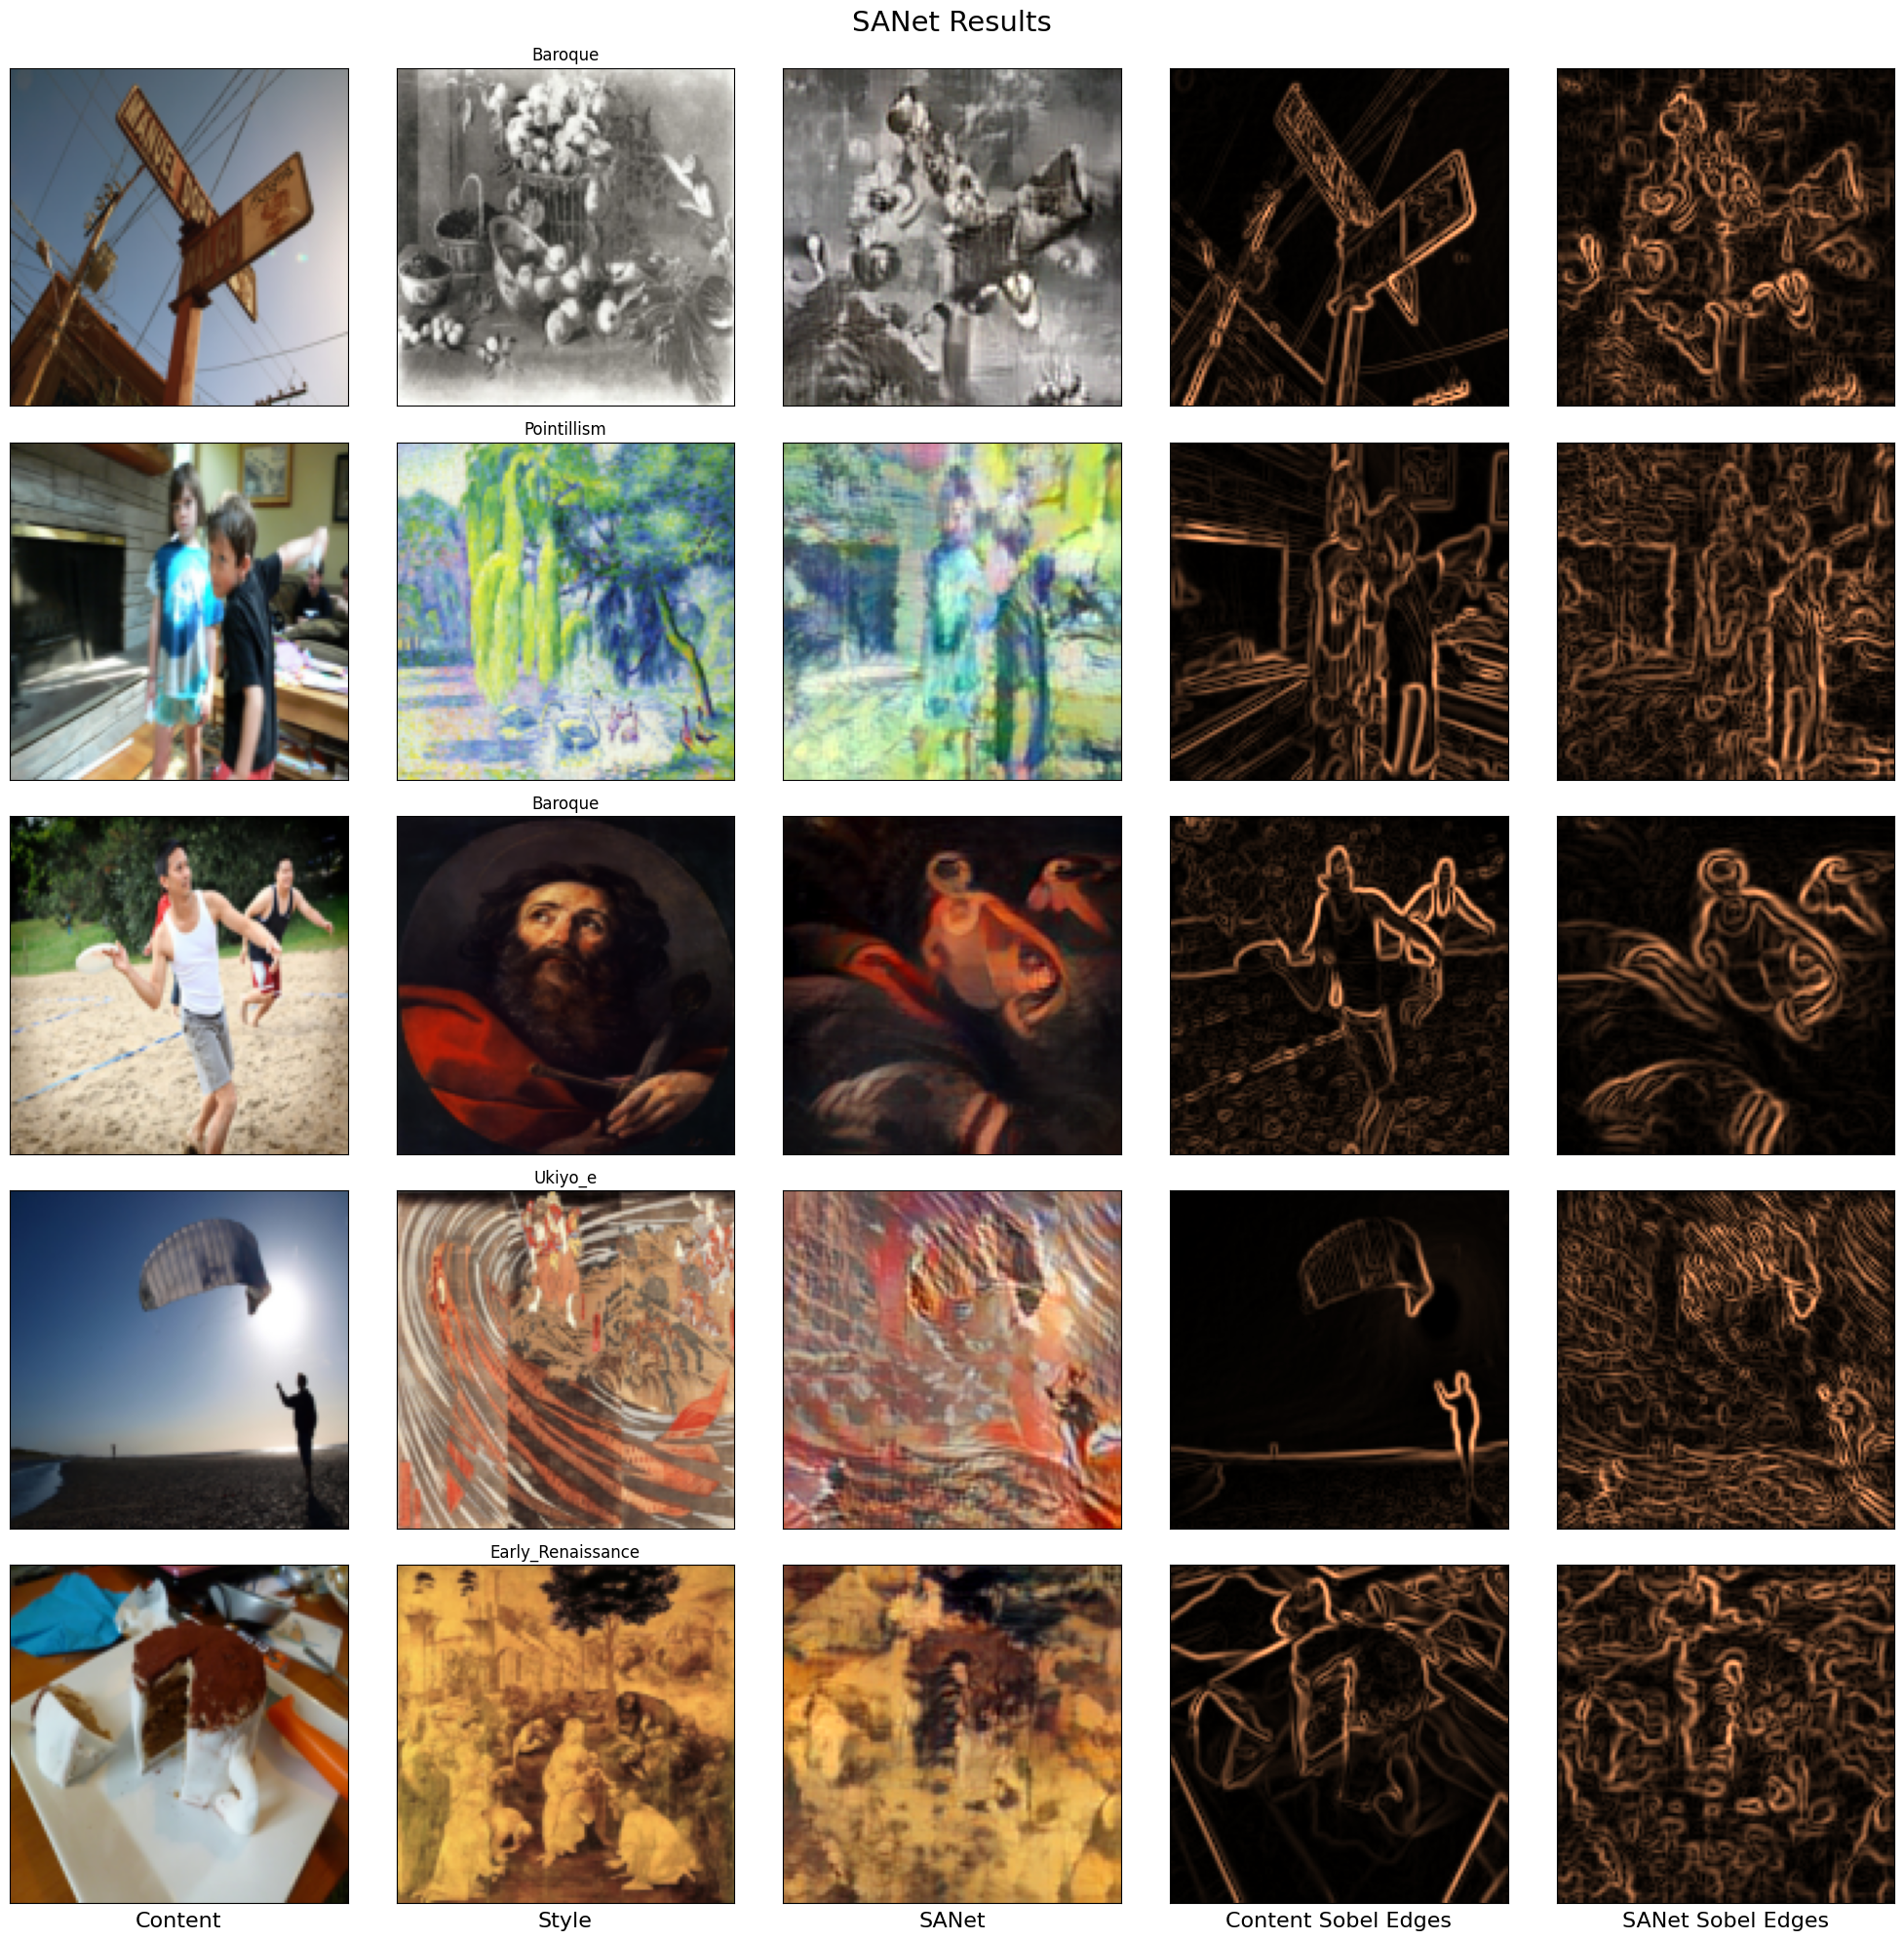

--- SANet results ---
Average SSIM = 0.2778
Average content loss = 0.0772
Average style loss = 0.0071


In [6]:
SANet_ssim, SANet_content_loss, SANet_style_loss = SANet_eval(decoder, vgg, transform, content_validloader, style_validloader)
print("--- SANet results ---")
print(f"Average SSIM = {SANet_ssim:.4f}")
print(f"Average content loss = {SANet_content_loss:.4f}")
print(f"Average style loss = {SANet_style_loss:.4f}")